# Lab 3 — dimensionality reduction

In [43]:
import json
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
from pyspark.mllib.linalg.distributed import CoordinateMatrix
import pandas as pd
from numpy import linalg as LA
import pickle
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()
from sklearn.linear_model import LinearRegression

%matplotlib inline
plt.style.use("ggplot")

Loading BokehJS ...

For some movies we have that it has a vector of scores for each tag in a set of tags. This results in a high-dimensional interpretation of each movie (**"tag space"**).

* **GOAL:** we want to represent this movies in a lower dimensional space using PCA.

Bellow one can see how the data looks like:

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 5

{"tagId": 1124, "tag": "writing"}
{"tagId": 1125, "tag": "wuxia"}
{"tagId": 1126, "tag": "wwii"}
{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [3]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 5

{"relevance": 0.58775, "tagId": 1124, "movieId": 131170}
{"relevance": 0.010749999999999982, "tagId": 1125, "movieId": 131170}
{"relevance": 0.015749999999999986, "tagId": 1126, "movieId": 131170}
{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}


In [4]:
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag_scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

IDT = dict(tags.map(itemgetter("tagId", "tag")).collect())

## Exercise 3.1

Construct an $M*N$ data matrix, where $M$ is the number of tags and $N$ the number of movies.
Do not include movies which do not have any tag.

* Plot the variance of each dimension (represented by tags) across all movies.
* Plot the eigenvalues of the $M*M$ covariance matrix.
* Explain the implications for dimensionality reduction.

For example, how many principal directions do you need to capture 2/3 of the variability in
the data?

-------------------------------------------------------------------------------------------------

How can we find the matrix $M*N$? In one file we do have a vector $M*N$ with all the scores for each movie. We should be able to transform that structure into the matrix.

In [5]:
# As found in the notebook "Intro_spark_EDA"
M = 1128 # tags
N = 10381 # movies with tags

In [6]:
matrix = tag_scores.map(itemgetter("tagId", "movieId", "relevance"))
matrix = np.asarray(matrix.collect())

In [7]:
matrix = np.asarray(matrix)

In [8]:
matrix[1:10]

array([[ 2.     ,  1.     ,  0.025  ],
       [ 3.     ,  1.     ,  0.05775],
       [ 4.     ,  1.     ,  0.09675],
       [ 5.     ,  1.     ,  0.14675],
       [ 6.     ,  1.     ,  0.217  ],
       [ 7.     ,  1.     ,  0.067  ],
       [ 8.     ,  1.     ,  0.26275],
       [ 9.     ,  1.     ,  0.262  ],
       [10.     ,  1.     ,  0.032  ]])

In [9]:
n = len(matrix)
A = np.zeros((1129,10381)) # 1128 tags, 10381 movies
m = -1
moviesID = np.zeros(10381)

for i in range(0,n):
    if i % 1128 == 0:
        m = m + 1
        moviesID[m] = matrix[i][1]
    
    A[int(matrix[i][0])][m] = matrix[i][2]

Now the matrix $A$ has the values we wanted to. **Keep in mind that A rows start at 1 and columns at 0.**

In [10]:
A[0]

array([0., 0., 0., ..., 0., 0., 0.])

### a) PLOT VARIANCE OF EACH DIMENSION (TAG) ACROSS ALL MOVIES:

$X = [x_1, ..., x_N]$, is our dataset. Each $X_i$ is a movie of dimension $M$, with all the scores for the different tags.

We want to know the covariance matrix of a given movie $x$. We know that: 
$$\mathrm{Var}(x) = \mathbb{E}[(x-\mathbb{E}[x])^2]$$
Then, we will center our matrix (all the data points) and then estimate the covariance matrix:
1. $X = X - \overline{X}$
2. $\mathrm{Var}(x) \approx \frac{1}{N}X X^T$

In [11]:
X = A
X = X - X.mean(1).reshape([1129,1])
CX = (1/N)*np.matmul(X,X.transpose())
CX.max()

0.08229289099080686

Now lets plot the diagonal so that we can see the variance of each dimension:

In [12]:
var = CX.diagonal()
var = var[1:] # first dimension is not a tag

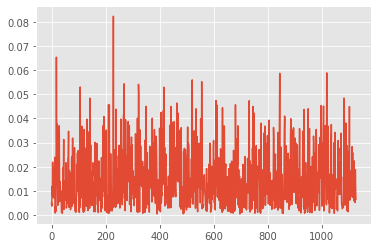

In [13]:
plt.plot(var)

### b) PLOT THE EIGENVALUES OF THE COVARIANCE MATRIX:

The 50 first eigenvalues in order are: [2.75311225 1.22135338 0.99595557 0.66211171 0.58567336 0.47428225
 0.46138018 0.39717058 0.34148576 0.28886558 0.26078631 0.23377844
 0.22231846 0.20775102 0.19270798 0.17735516 0.16994217 0.15259553
 0.13731592 0.1314468  0.12068555 0.11253595 0.10944098 0.10015725
 0.09424449 0.08813647 0.08342501 0.0809259  0.07804268 0.07487721
 0.07136622 0.06806269 0.06664784 0.06213607 0.06124358 0.05824564
 0.05701822 0.05567969 0.05364679 0.05295612 0.0502332  0.04963194
 0.04797178 0.04700254 0.04454992 0.04390238 0.04314391 0.04129978
 0.04085629 0.0394823 ]


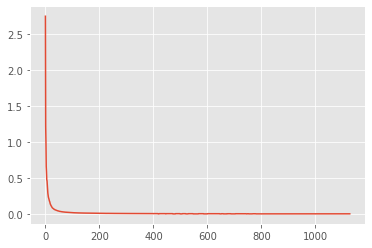

In [14]:
eva, eve = LA.eig(CX[1:,1:])
plt.plot(eva)
print("The 50 first eigenvalues in order are:", eva[0:50])

### c) THE IMPLICATIONS FOR DIMENSIONALITY REDUCTION:

The implications are that the variance is mostly accumulated in the directions of the first eigenvalues, which will allow us to draw a low dimensional space in which most of the variance will still be present. Basically we have that:
$$X X^T = V D V^T$$
$$X X^T = D \sum_{i = 1}^{M}v_i v_i^T$$
Where $V = [v_1,...,v_M]$ (ordered higher to smaller) are the eigenvectors and $D$ the eigenvalues. Keeping the highest eigenvalues with their eigenvectors will be able to reconstruct most of the covariance matrix.

Now let us see how many direaction do we need in order to capture 2/3 of the total variance.

In [15]:
print("The tota variance is", sum(eva), "and the first 36 directions (1128 in total) account for", 100 * sum(eva[0:36])/sum(eva), "percent of the total variance.")

The tota variance is 17.100245817365952 and the first 36 directions (1128 in total) account for 66.65145090563256 percent of the total variance.


## Exercise 3.2: Concept Space

For the five first principal directions, find the 10 tags that have the highest and lowest
coordinates in that direction.

* What concepts would you use to describe these dimensions?

Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal
directions and save it to disk. This will be used later for the clustering exercise.

**NOTE:** We are going to find the 10 highest (absolute value) coordinates of each component. This means that within the direction they are the most meaningful tags.

In [16]:
# IMPORTANT TO REMEMBER: pc1 indexes go from 0 to 1127, but real tags are 1 to 1128.

pc1 = eve[0]
pc2 = eve[1]
pc3 = eve[2]
pc4 = eve[3]
pc5 = eve[4]

aux1 = pc1.argsort()[-5:][::-1]
#print(aux1)
tags1 = [IDT[key+1] for key in aux1]
print(tags1)
#print(pc1[aux1])

aux2 = pc1.argsort()[:5][::-1]
tags2 = [IDT[key+1] for key in aux2]
print(tags2)
#print(pc1[aux2])

['iran', 'irish', 'interesting', 'iraq', 'remake']
['romantic', 'reality tv', 'irish accent', 'investigation', 'iraq war']


In [17]:
aux1 = pc2.argsort()[-5:][::-1]
tags1 = [IDT[key+1] for key in aux1]
print(tags1)
#print(pc1[aux1])

aux2 = pc2.argsort()[:5][::-1]
tags2 = [IDT[key+1] for key in aux2]
print(tags2)
#print(pc1[aux2])

['reality tv', 'pointless', 'photographer', 'runaway', 'reflective']
['oscar (best supporting actor)', 'neil gaiman', 'remake', 'remade', 'poetry']


In [18]:
aux1 = pc3.argsort()[-5:][::-1]
tags1 = [IDT[key+1] for key in aux1]
print(tags1)
#print(pc1[aux1])

aux2 = pc3.argsort()[:5][::-1]
tags2 = [IDT[key+1] for key in aux2]
print(tags2)
#print(pc1[aux2])

['emma watson', 'love story', 'dolphins', 'farce', 'exciting']
['holocaust', 'beautifully filmed', 'disappointing', 'classic car', 'drug addiction']


In [19]:
aux1 = pc4.argsort()[-5:][::-1]
tags1 = [IDT[key+1] for key in aux1]
print(tags1)
#print(pc1[aux1])

aux2 = pc4.argsort()[:5][::-1]
tags2 = [IDT[key+1] for key in aux2]
print(tags2)
#print(pc1[aux2])

['queer', 'silly fun', 'surrealism', 'steampunk', 'politics']
['noir thriller', 'paris', 'robert downey jr', 'psychedelic', 'sex']


In [20]:
aux1 = pc5.argsort()[-5:][::-1]
tags1 = [IDT[key+1] for key in aux1]
print(tags1)
#print(pc1[aux1])

aux2 = pc5.argsort()[:5][::-1]
tags2 = [IDT[key+1] for key in aux2]
print(tags2)
#print(pc1[aux2])

['camp', 'based on comic', 'best war films', 'beer', 'berlin']
['artist', 'computers', 'campy', 'baseball', 'book']


#### Let us create the dictionary:

The dictionary IDT ranges from key 1 to 1128. We will create a dictionary in which every tagID **i** will reference the correspondent coordinate of each component:
``dict[i] = [pc1[i], ..., pc5[i]]``

In [21]:
d = {}
for i in range(1,1129):
    l = [pc1[i-1],pc2[i-1],pc3[i-1],pc4[i-1],pc5[i-1]] # The index in pc1 is 0 to 1127 (real tag 1 to 1128)
    d.update({i : l})

In [22]:
d[559] # as expected :)

[0.21590706096480425,
 0.054900558584922425,
 -0.000517771758664586,
 -0.013724703477853784,
 0.003454430925274809]

Now to save it:

In [23]:
f = open("tag_to_5pc","wb")
pickle.dump(d,f)
f.close()

## Exercise 3.3: Movie Visualization

Project the movies of selected-movies.pickle on the first two principal directions.

* Create an interactive plot that displays the 2D-projection of the movies using bokeh and its hover tool. Color the nodes by their Rotten Tomatoes score.
* Based on your knowledge of these movies and information that you can get from the web, explain the coordinates of a few of the movies.
* How do the PCA directions correlate with the Rotten Tomatoes score?

Try projecting the movies on subsequent principal directions. Does it make sense based on
your knowledge of these movies? (Not needed for the hand-in).

In [24]:
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")

This is a set of 37 movies, each of them is (movieID, Title, RTScore).

#### Projection:

How do we project the images in the first 2 principal components? Given that:
$$V^T x_e = x_v$$
Meaning the image in the canonical base ($x_e$) or in the eigenvectors space ($x_v$). Since in the $V$ space the vectors are orthogonal (symetric matrix) the projection on the first 2 vectors of $V$ ($v_1,v_2$) will be just keeping the coordinates:
$$x_v = a_1 v_1 + ... + a_M$$
$$x_{\text{projected}} = a_1 v_1 + a_2 v_2$$

In [26]:
moviesID

array([1.00000e+00, 2.00000e+00, 3.00000e+00, ..., 1.31013e+05,
       1.31168e+05, 1.31170e+05])

In [38]:
A

array([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.025  , 0.03975, 0.0435 , ..., 0.042  , 0.05975, 0.05325],
       [0.025  , 0.04375, 0.05475, ..., 0.03175, 0.10375, 0.08625],
       ...,
       [0.03625, 0.01475, 0.0195 , ..., 0.0095 , 0.51925, 0.01575],
       [0.07775, 0.09025, 0.097  , ..., 0.0755 , 0.067  , 0.1145 ],
       [0.023  , 0.01875, 0.0185 , ..., 0.01625, 0.01725, 0.02175]])

In [48]:
aux_id = 1
aux = np.where(moviesID == aux_id) # this tells you the position
score = A[1:,aux].reshape(M,1)

In [42]:
movies[0]

(780, 'Independence Day (a.k.a. ID4) (1996)', 0.6)

Now we want to have ($x_1$, $x_2$, movie name, score).

In [56]:
l = []
for i, e in enumerate(movies):
    # First of all the vector:
    aux_id = e[0]
    aux = np.where(moviesID == aux_id)
    x_e = A[1:,aux].reshape(M,1) # This is the ector
    
    # Projection of score to eigenvectors:
    x_v = np.dot(np.transpose(eve),x_e) # first 2 components coordinates are projection :)
    
    l.append([float(x_v[0]),float(x_v[1]),e[1],e[2]]) # (x_1,x_2,title,score)

In [73]:
# Continuous colors
from matplotlib.colors import rgb2hex 
cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

data = l
source = ColumnDataSource(
    data={
        "x": [x[0] for x in data],
        "y": [x[1] for x in data],
        "title": [x[2] for x in data],
        "color": [val2rgb(x[3]) for x in data],
        "score": [x[3] for x in data]
    })

hover = HoverTool(
    tooltips=[
        ("Title", "@title"), ("Score", "@score")
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

I would like to see the movies and why are where they are:

In [87]:
movies

((780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (5349, 'Spider-Man (2002)', 0.89),
 (2571, 'Matrix, The (1999)', 0.87),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (2329, 'American History X (1998)', 0.83),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (55444, 'Control (2007)', 0.87),
 (32296, 'Miss Congeniality 2: Armed and Fabulous (2005)', 0.15),
 (43930, 'Just My Luck (2006)', 0.13),
 (4658, 'Santa Sangre (1989)', 0.85),
 (6774, 'Videodrome (1983)', 0.78),
 (3967, 'Billy Elliot (2000)', 0.85),
 (114028, 'Pride (2014)', 0.92),
 (480, 'Jurassic Park (1993)', 0.93),
 (260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (527, "Schindler's List (1993)", 0.96),
 (2959, 'Fight Club (1999)', 0.79),
 (6132, 'New York Ripper, The (Squartatore di New York, Lo) (1982)', 0.17),
 (2858, 'American Beauty (1999)', 0.88),
 (6016, 'City of God (Cidade de Deus) (2002)', 0.9),
 (94018, 'Battleship (2012)', 0.34),
 (5687,

In [101]:
ex = 6016 # city of god
np.where(moviesID == 6016)
ex = 5189
np.max(A[:,5189])

0.9922500000000001

It looks like the higher values of the first component and lower of the second imply better results.

#### Correlations:

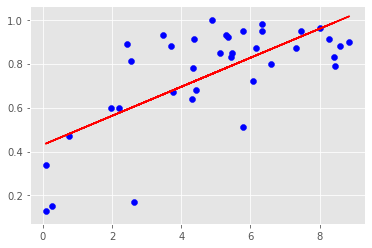

In [86]:
c1 = np.array([aux[0] for aux in l]).reshape(-1,1)
sc = np.array([aux[3] for aux in l]).reshape(-1,1)

linear_regressor = LinearRegression()
linear_regressor.fit(c1, sc)  # perform linear regression
sc_pred = linear_regressor.predict(c1)  # make predictions
plt.scatter(c1, sc, c='blue')
plt.plot(c1, sc_pred, color='red')

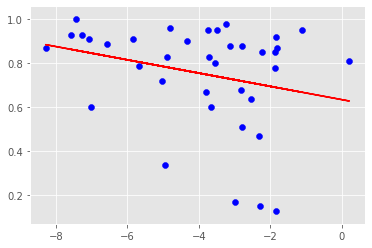

In [85]:
c2 = np.array([aux[1] for aux in l]).reshape(-1,1)
sc = np.array([aux[3] for aux in l]).reshape(-1,1)

linear_regressor = LinearRegression()
linear_regressor.fit(c2, sc)  # perform linear regression
sc_pred = linear_regressor.predict(c2)  # make predictions
plt.scatter(c2, sc, c='blue')
plt.plot(c2, sc_pred, color='red')